In [1]:
%reload_ext tensorboard
%reload_ext autoreload

# Normalising Manifold Flows

In [2]:
import os
import time
import math
import torch
import numpy as np
import torch.nn as nn
import pytorch_lightning as pl
import torch.nn.functional as F
import torch.distributions as tdist
import torchdyn.nn.node_layers as tdnl

from enum import Enum
from joblib import dump, load
from sklearn.decomposition import PCA
from pdmtut.core import GenerativeModel
from pytorch_lightning import loggers as pl_loggers
from regilib.core.distributions import MultivariateNormal
from regilib.core.dynamics.dynamics import RegularisedDynamics, StateDynamics
from regilib.core.dynamics.dynamical_state import DynamicalState
from regilib.core.invertible_modules import NormalisingFlow
from regilib.core.invertible_modules.charts import PadProj
from regilib.core.invertible_modules.bijective import ContinuousAmbientFlow, ContinuousManifoldFlow

In [3]:
store_results = True
load_models = True

## Introduction

## Implementation

In [4]:
class NormalisingManifoldFlow(NormalisingFlow, pl.LightningModule, GenerativeModel):
    class State(Enum):
        """State that the manifold is in."""

        MANIFOLD_LEARNING = 1
        DENSITY_LEARNING = 2
        INFERENCE = 3
    
    class FunctionDynamicsH(nn.Module):
        """ Models the dynamics of the ambient flow on the manifold. """

        def __init__(self):
            super().__init__()
            self._in_channels = 2
            self._out_channels = 2

            # expected format: N x (C * L)
            # +1 for time
            self.fc1 = nn.Linear(self.in_channels + 1, 128)
            self.fc2 = nn.Linear(128, 256)
            self.fc3 = nn.Linear(256, 256)
            self.fc4 = nn.Linear(256, 128)
            self.fc5 = nn.Linear(128, self.out_channels)

        @property
        def in_channels(self):
            return self._in_channels

        @property
        def out_channels(self):
            return self._out_channels

        def forward(self, ds):
            x = torch.cat([ds.state, ds.t], -1)
            x = torch.tanh(self.fc1(x))
            x = torch.tanh(self.fc2(x))
            x = torch.tanh(self.fc3(x))
            x = torch.tanh(self.fc4(x))
            x = self.fc5(x)
            return x
    
    class FunctionDynamicsF(nn.Module):
        """ Models the dynamics of the injection to the manifold. """

        def __init__(self):
            super().__init__()
            self._in_channels = 3
            self._out_channels = 3

            # expected format: N x (C * L)
            # +1 for time
            self.fc1 = nn.Linear(self.in_channels + 1, 128)
            self.fc2 = nn.Linear(128, 256)
            self.fc3 = nn.Linear(256, 256)
            self.fc4 = nn.Linear(256, 128)
            self.fc5 = nn.Linear(128, self.out_channels)

        @property
        def in_channels(self):
            return self._in_channels

        @property
        def out_channels(self):
            return self._out_channels

        def forward(self, ds):
            x = torch.cat([ds.state, ds.t], -1)
            x = torch.tanh(self.fc1(x))
            x = torch.tanh(self.fc2(x))
            x = torch.tanh(self.fc3(x))
            x = torch.tanh(self.fc4(x))
            x = self.fc5(x)
            return x
    
    def __init__(self, chart=PadProj()):
        super().__init__(
            base_distribution=MultivariateNormal(torch.zeros(2), torch.eye(2))
        )

        # state=[l, e, n | state]
        self.aug1 = tdnl.Augmenter(augment_dims=3)
        self.af1 = ContinuousAmbientFlow(
            dynamics=RegularisedDynamics(
                fdyn=NormalisingManifoldFlow.FunctionDynamicsH()
            ),
            sensitivity='autograd', default_n_steps=2
        )
        self.mf1 = ContinuousManifoldFlow(
            chart=chart, dynamics=StateDynamics(
                fdyn=NormalisingManifoldFlow.FunctionDynamicsF()
            ),
            sensitivity='autograd', default_n_steps=5
        )
        
        self.state = NormalisingManifoldFlow.State.INFERENCE

    # Region NormalisingFlow
    def forward(self, x, af_estimate=True, mf_skip=True):
        ds = x.clone() if isinstance(x, DynamicalState) else DynamicalState(state=x)

        # p(z)
        ds = super().forward(ds)

        # u=h(z)
        ds = self.af1.dynamics.update_ds(ds, self.aug1(ds['state']))
        ds = self.af1.forward(ds, estimate_trace=af_estimate)

        # x=g(u)
        ds = self.mf1.forward(ds, skip_jacobian_det=mf_skip)
        return ds

    def inverse(self, x, af_estimate=True, mf_skip=True):
        ds = x.clone() if isinstance(x, DynamicalState) else DynamicalState(state=x)

        # u=g⁻¹(x)
        ds = self.mf1.inverse(ds, skip_jacobian_det=mf_skip)

        # z=h⁻¹(u)
        ds = self.af1.dynamics.update_ds(ds, self.aug1(ds['state']))
        ds = self.af1.inverse(ds, estimate_trace=af_estimate)

        # p(z)
        ds = super().inverse(ds)
        return ds
    
    # Region GenerativeModel
    def encode(self, X):
        ds = self.inverse(X)
        return ds['state'].cpu().detach()

    def decode(self, z):
        ds = self.forward(z)
        return ds['state'].cpu().detach()
        
    def save(self, path):
        torch.save(self, os.path.join(path, 'model.pt'))
    
    def load(path):
        return torch.load(os.path.join(path, 'model.pt'))
            
    def save_exists(path):
        return (
            os.path.isfile(os.path.join(path, 'model.pt')))
    
    def log_likelihood(self, x):
        ds_z = self.inverse(ds_x, af_estimate=False, mf_skip=False)
        return ds_z.log_prob.cpu().detach()

    def sample_posterior(self, n_samples):
        ds = super().sample_posterior(n_samples)
        return ds['state'].detach().cpu()
    
    # Region training
    def fit_model(self, X, X_val=None, path=None):
        start_time = time.time()
        
        if path is None:
            tb_logger = False
            checkpoint_callback=False
        
        # MANIFOLD PHASE
        self.state = NormalisingManifoldFlow.State.MANIFOLD_LEARNING
        self.mf1.freeze(False); self.af1.freeze(True)
        
        if path is not None:
            tb_logger = pl_loggers.TensorBoardLogger(
                os.path.join(path, 'mp/'), version=2)
            checkpoint_callback=True

        trainer = pl.Trainer(
            max_epochs=40000, gpus=1, logger=tb_logger,
            checkpoint_callback=checkpoint_callback
        )
        
        trainer.fit(self, train_dataloaders=X, val_dataloaders=X_val)
        
        # DENSITY PHASE
        self.state = NormalisingManifoldFlow.State.DENSITY_LEARNING
        self.mf1.freeze(True); self.af1.freeze(False)
        
        if path is not None:
            tb_logger = pl_loggers.TensorBoardLogger(
                os.path.join(path, 'dp/'), version=0)
            checkpoint_callback=True
        
        trainer = pl.Trainer(
            max_epochs=1, gpus=1, logger=tb_logger,
            checkpoint_callback=checkpoint_callback
        )
        
        trainer.fit(self, train_dataloaders=X, val_dataloaders=X_val)

        # INFERENCE PHASE
        self.state = NormalisingManifoldFlow.State.INFERENCE
        
        elapsed_time = time.time() - start_time
        if path is not None: 
            with open(os.path.join(path, 'training_time.txt'), 'w') as f:
                f.write(str(elapsed_time))
                
    # region training
    def noise_enhance_data(self, x, b=0.1):
        nu = torch.randn(x.shape[0], 3, device=x.device) * b
        return x + nu
    
    def train_step_g(self, x):
        #print('NO NOISE ADDED!!!')
        #from IPython.core.debugger import Pdb; Pdb().set_trace()
        # add noise to data
        x_prime = self.noise_enhance_data(x, b=0.01)
        ds = DynamicalState(state=x_prime)

        # project point to manifold
        ds_u = self.mf1.inverse(ds, skip_jacobian_det=True)

        # reconstruct point
        ds_x = self.mf1.forward(ds_u, skip_jacobian_det=True)

        mse = (x - ds_x['state']).pow(2).sum(-1)

        # energy
        loss = mse.sum() / (x.shape[0]*x.shape[1])

        return loss

    def train_step_h(self, x):
        lambda_e, lambda_n = 0.01, 0.01

        # logp(z_t1) = logp(z_t0) - \int_0^1 - Tr ∂f/∂z(t)
        ds_z = self.inverse(x, af_estimate=True, mf_skip=True)

        # negative log likelihood
        loss = (
            -ds_z.log_prob + lambda_e * ds_z.e[:, 0] + lambda_n * ds_z.n[:, 0]
        ).sum() / (x.shape[0]*x.shape[1])

        return loss

    def training_step(self, batch, batch_idx):
        x = batch[0]

        if self.state is NormalisingManifoldFlow.State.MANIFOLD_LEARNING:
            loss = self.train_step_g(x)
        if self.state is NormalisingManifoldFlow.State.DENSITY_LEARNING:
            loss = self.train_step_h(x)

        self.log('train_loss', loss)
        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        x = batch[0]

        if self.state is NormalisingManifoldFlow.State.MANIFOLD_LEARNING:
            loss = self.train_step_g(x)
        if self.state is NormalisingManifoldFlow.State.DENSITY_LEARNING:
            loss = self.train_step_h(x)

        self.log('validation_loss', loss)
        return {'val_loss': loss}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return {
            'optimizer': optimizer,
            'lr_scheduler':
            torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, min_lr=1e-8, factor=0.9, verbose=True,
                patience=5000
            ),
            'monitor': 'train_loss'
        }

    def __str__(self):
        return 'nflows'


## Experiment 1: swiss roll

In [5]:
import pyvista as pv
from pdmtut.datasets import SwissRoll

In [6]:
pv.set_plot_theme("document")

model_save_path = '../results/swiss_roll/nmf'

if store_results:
    result_save_path = '../results/swiss_roll/nmf'
    pv.set_jupyter_backend('None')
else:
    pv.set_jupyter_backend('ipygany')
    result_save_path = None

In [7]:
dataset = SwissRoll(n_samples=100**2, seed=11)

if load_models and NormalisingManifoldFlow.save_exists(model_save_path):
    model = NormalisingManifoldFlow.load(model_save_path)
else:
    model = NormalisingManifoldFlow()
    model.fit_model(
        X=dataset.train_loader(batch_size=2**12),
        X_val=dataset.validation_loader(batch_size=512),
        path=result_save_path)
    
    if store_results:
        model.save(model_save_path)
        
model = model.eval()

In [8]:
x = dataset.X
ds = DynamicalState(state=x)

# project point to manifold
ds_u = model.mf1.inverse(ds.clone(), skip_jacobian_det=True)

# reconstruct point
ds_x = model.mf1.forward(ds_u.clone(), skip_jacobian_det=True, include_trajectory=True, steps=10)

mse = (x - ds_x['state']).pow(2).sum(-1)


In [12]:
plotter = pv.Plotter()
plotter.add_mesh(pv.PolyData(ds_x.trajectory[0].numpy()), render_points_as_spheres=True, color='red')
plotter.add_mesh(pv.PolyData(dataset.X.numpy()), render_points_as_spheres=True, opacity=0.1, color='green')
plotter.camera_position = [(0, 5, 5), (0, 0, 0), (0, 1, 0)]

plotter.show_grid()
plotter.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [10]:
from regilib.vis.video_plotter import plot_video
import pyvista as pv

plot_video(
    ds_x.trajectory, 'mflow_test.gif', render_points_as_spheres=True, reverse=True, 
    camera_pos = [(0, 3, 5), (0, 0, 0), (0, 1, 0)],    
)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [11]:
%tensorboard --logdir ../results/swiss_roll/nmf

### Input Representation

In [30]:
from pdmtut.vis import plot_representation

In [31]:
z = model.encode(dataset.X)
z_extremes = model.encode(dataset.y_extremes)

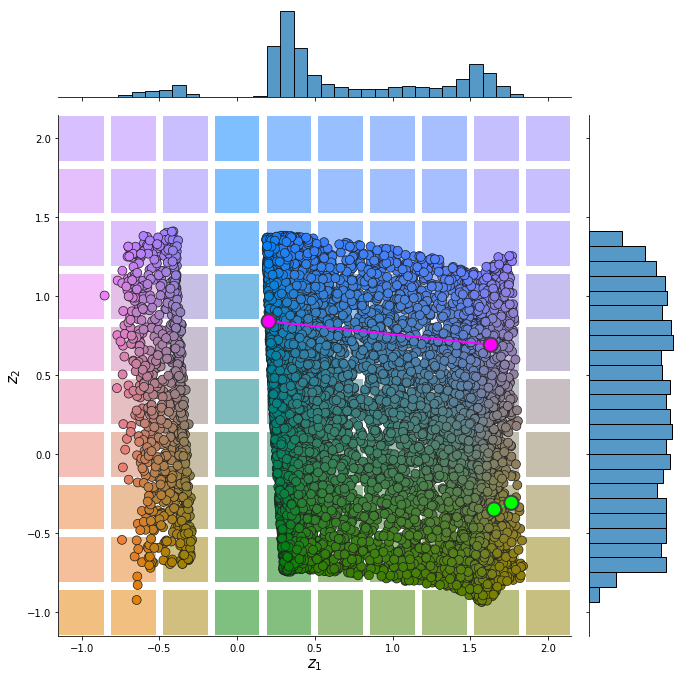

In [32]:
plot_representation(z.numpy(), index_colors=dataset.index_colors, z_extremes=z_extremes, interpolate_background=True, root=result_save_path)

### Input Reconstruction

In [15]:
from pdmtut.vis import plot_reconstruction

In [16]:
z = model.encode(dataset.X)
x = model.decode(z)

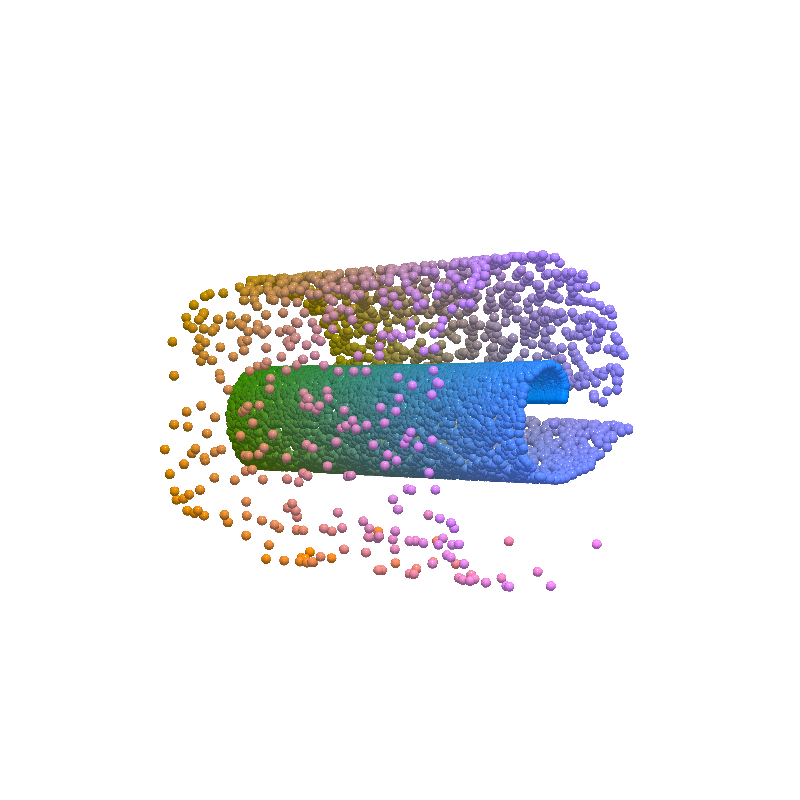

In [17]:
plot_reconstruction(dataset.unnormalise_scale(x).numpy(), dataset.index_colors, root=result_save_path)

### Density Estimation

In [18]:
from pdmtut.vis import plot_density

In [19]:
log_likelihood = model.log_likelihood(dataset.X)

NameError: name 'log_prob_computor' is not defined

In [ ]:
plot_density(dataset.unnormalise_scale(dataset.X).numpy(), log_likelihood.numpy(), root=result_save_path)

### Generate Samples

In [23]:
from pdmtut.vis import plot_generated_samples

In [24]:
generated_samples = model.sample_posterior(100**2)
#generated_samples_log_likelihood = model.log_likelihood(generated_samples)
generated_samples_log_likelihood = torch.zeros(100**2)

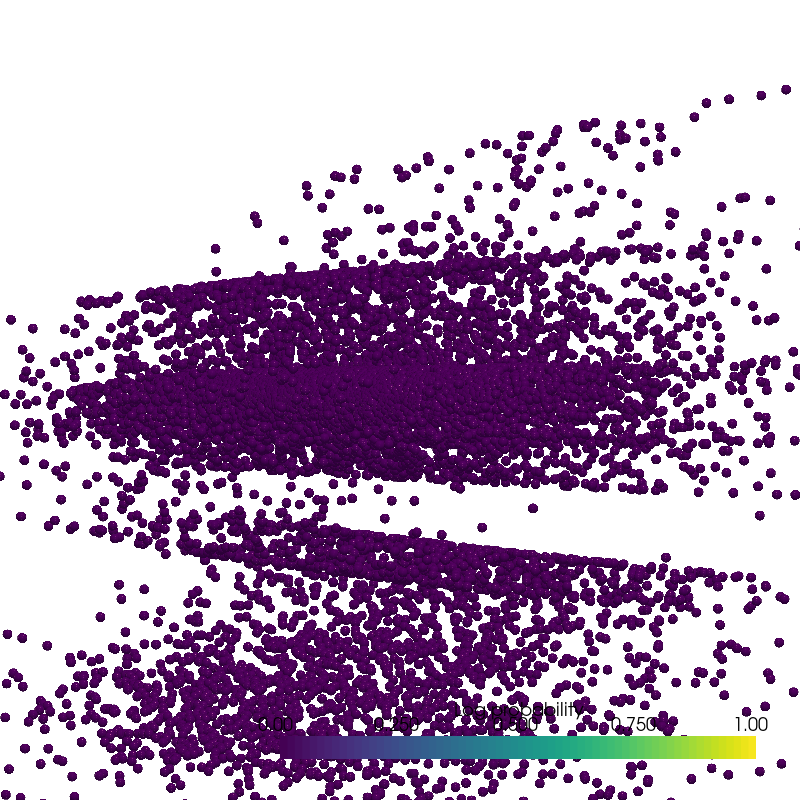

In [25]:
plot_generated_samples(dataset.unnormalise_scale(generated_samples).numpy(), generated_samples_log_likelihood.numpy(), root=result_save_path)

### Interpolation

In [26]:
from pdmtut.vis import plot_interpolation
from scipy.interpolate import interp1d

In [27]:
z_extremes = model.encode(dataset.y_extremes)
uniform_state, uniform_log_prob, _ = dataset.sample_points_uniformly(n_samples=100**2, seed=11)

linfit1 = interp1d([1,20], z_extremes[:2].numpy(), axis=0)
linfit2 = interp1d([1,20], z_extremes[2:].numpy(), axis=0)

interpolated_points_1 = model.decode(torch.Tensor(linfit1(np.arange(1,21))))
interpolated_points_2 = model.decode(torch.Tensor(linfit2(np.arange(1,21))))

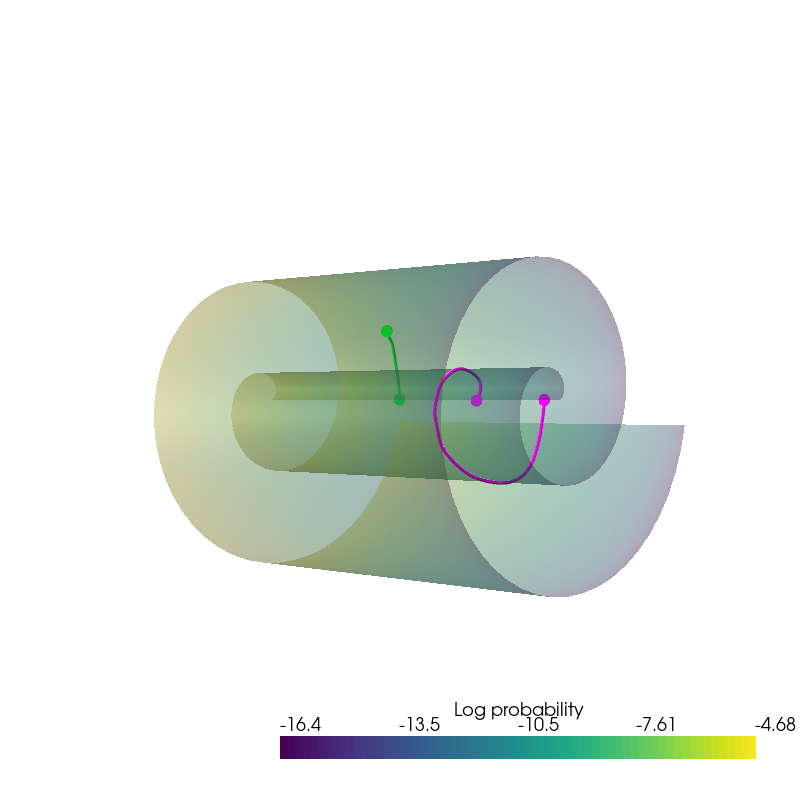

In [28]:
plot_interpolation(
    dataset.unnormalise_scale(interpolated_points_1).numpy(), 
    dataset.unnormalise_scale(interpolated_points_2).numpy(), 
    uniform_state.detach().view(100, 100, 3).permute(2, 0, 1).numpy(),
    uniform_log_prob.numpy(), root=result_save_path
)